# 05_Recurrent Neural Networks

## Setup

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals
from IPython.display import HTML

# Common imports
import numpy as np
import os
import tensorflow as tf

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

import matplotlib.image as mpimg
def plot_external(img):
    img_name = os.path.join(".", "images",img)
    plots = mpimg.imread(img_name)
    plt.axis("off")
    plt.imshow(plots)    
    plt.show()
    
def plot_external2(imgpath):    
    plots = mpimg.imread(imgpath)
    plt.axis("off")
    plt.imshow(plots)    
    plt.show()
    
def mnist_load_data():
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
    X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
    X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
    y_train = y_train.astype(np.int32)
    y_test = y_test.astype(np.int32)
    X_valid, X_train = X_train[:5000], X_train[5000:]
    y_valid, y_train = y_train[:5000], y_train[5000:]
    
    return (X_train, y_train), (X_valid, y_valid), (X_test, y_test)

# progress bar
from tqdm import tqdm_notebook

# batch function
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

## 5.1 Recurrent Neurons

각 타임 스텝(time step)(또는 frame)마다 이 순환 뉴런(recurrent neuron)은 $\mathbf{x}_{t}$는 물론 이전 타임 스텝의 출력인 $y_{(t-1)}$을 입력으로 받습니다. 이 작은 네트워크를 오른쪽처럼 시간을 축으로 하여 표현할 수 있습니다. 이를 **시간에 따라 네트워크를 펼쳤다**라고 말합니다.

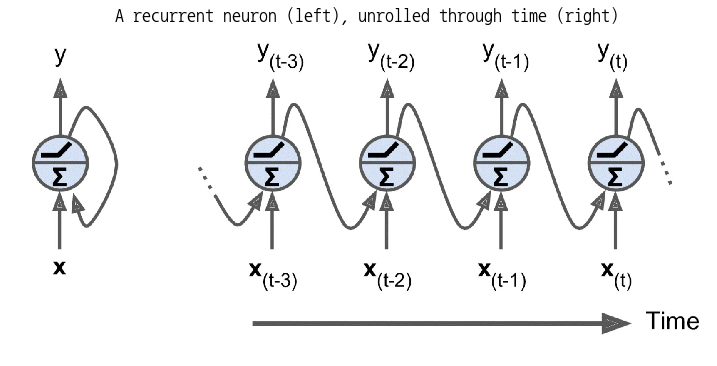

In [3]:
plt.figure(figsize=(12, 8))
plt.title("A recurrent neuron (left), unrolled through time (right)", fontsize=18)
plot_external2("./images/rnn/1.png")
plt.show()

순환 뉴런으로 된 층은 쉽게 만들 수 있습니다. 아래 그림처럼 타임 스텝 t마다 모든 뉴런은 입력 벡터 $\mathbf{x}_{(t)}$와 이전 타임 스텝의 출력 벡터 $\mathbf{y}_{(t-1)}$을 받습니다. 이제 입력과 출력이 모두 벡터가 됩니다(뉴런이 하나일 때는 출력이 스칼라입니다).

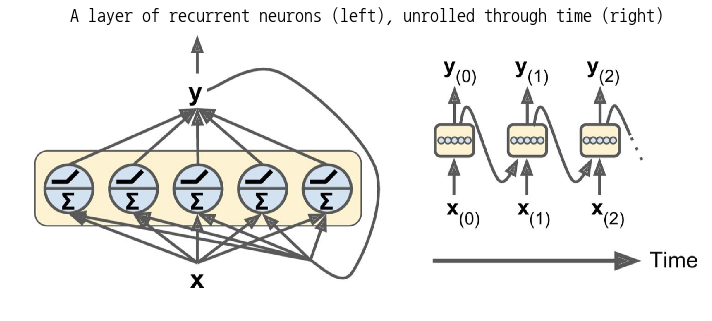

In [4]:
plt.figure(figsize=(12, 8))
plt.title("A layer of recurrent neurons (left), unrolled through time (right)", fontsize=18)
plot_external2("./images/rnn/2.png")
plt.show()

각 순환 뉴런은 두 벌의 가중치를 가집니다. 하나는 입력 $\mathbf{x}_{(t)}$를 위한 것이고 다른 하나는 이전 타임 스텝의 출력 $\mathbf{y_{(t-1)}}$을 위한 것입니다. 이 가중치 벡터를 $\mathbf{w}_{x}$와 $\mathbf{w}_y$라고 하겠습니다. 하나의 순환 뉴런이 아니라 순환 층 전체를 생각하면 가중치 벡터를 가중치 행렬 $\mathbf{W}_{x}$와 $\mathbf{W}_y$로 바꿀 수 있습니다. 그러면 순환 층 전체의 출력은 다음식과 같이 표현됩니다.

$$
    \mathbf{y}_{(t)} =\phi \left( 
{\mathbf{W}_{x}}^{T} \cdot \mathbf{x}_{(t)} + {\mathbf{W}_{y}}^{T} \cdot \mathbf{y}_{(t-1)} + \mathbf{b} 
 \right)
$$

- $\mathbf{b}$ : 편향  
- $\phi{ \left( \cdot \right)}$: 활성화함수  

타임 스텝 $t$에서의 모든 입력을 행렬 $\mathbf{X}_{(t)}$로 만들어 미니배치 전체에 대해 순환 층의 출력을 한번에 계산할 수 있습니다.  

$$
\begin{split}   
    \mathbf{Y}_{{t}} &= \phi \left( 
{\mathbf{W}_{x}}^{T} \cdot \mathbf{x}_{(t)} + {\mathbf{W}_{y}}^{T} \cdot \mathbf{y}_{(t-1)} + \mathbf{b} 
 \right)\\ 
 &= \phi\left(  
     \left[ 
         \mathbf{X}_{(t)}\mathbf{Y}_{(t-1)}
     \right]\cdot\mathbf{W} + \mathbf{b}
 \right), \qquad where\; 
 W=
 \begin{bmatrix}
     \mathbf{W}_x \\
     \mathbf{W}_y
 \end{bmatrix}
\end{split}
$$  

- $\mathbf{Y}_{(t)}$: 타임 스텝 $t$에서 미니배치에 있는 각 샘플에 대한 층의 출력을 담고 있는 $m \times n_{neurons}$행렬  
- $\mathbf{X}_{(t)}$: 모든 샘플의 입력값을 담고 있는 $m\times n_{inputs}$행렬  
- $\mathbf{W}_x$: 현재 타임 스텝의 입력에 대한 연결 가중치를 담고 있는 $n_{inputs}\times n_{neurons}$행렬  
- $\mathbf{W}_y$: 이전 타임 스텝의 출력에 대한 연결 가중치를 담고 있는 $n_{inputs} \times n_{neurons}$행렬  
- $\mathbf{b}$: 각 뉴런의 편향을 담고 있는 $n_{neurons}$크기의 벡터  
- 가중치 행렬 $\mathbf{W}_{x}$와 $\mathbf{W}_{y}$는 종종 $(n_{inputs}+n_{neurons})\times n_{neurons}$크기의 가중치 행렬 $\mathbf{W}$ 하나로 연결  
- $\left[\mathbf{X}_{(t)}\mathbf{Y}_{(t-1)}  \right]$표기는 행렬 $\mathbf{X}_{(t)}\mathbf{Y}_{(t-1)}$을 수평적으로 연결한다는 뜻  

$\mathbf{Y}_{(t)}$는 $\mathbf{X}_{(t)}$와 $\mathbf{Y}_{(t-1)}$의 함수고, $\mathbf{Y}_{(t-1)}$는 $\mathbf{X}_{(t-1)}$와 $\mathbf{Y}_{(t-2)}$의 함수고, $\mathbf{Y}_{(t-2)}$는 $\mathbf{X}_{(t-2)}$와 $\mathbf{Y}_{(t-3)}$의 함수가 되는 식입니다. 결국 $\mathbf{Y}_{(t)}$는 시간 $t=0$에서부터 모든 입력에 대한 함수가 됩니다(즉, $\mathbf{X}_{0},\,\mathbf{X}_{1},\,\cdots ,\, \mathbf{X}_{t}$). 첫 번째 타임 스텝 $t=0$에서는 이전 출력이 없으므로 보통 모두 0이라고 가정합니다.  

<br><br>

### 5.1.1 Memory Cells  
타임 스텝 $t$에서 순환 뉴런의 출력은 이전 타임 스텝의 모든 입력에 대한 함수이기 때문에 이를 일종의 **메모리(memory)** 형태라고 말할 수 있습니다. 타임 스텝에 걸쳐서 어떤 상태를 보존하는 신경망의 구성 요소를 **메모리 셀(memory cell)**혹은 간단히 **셀**이라고 합니다. 하나의 순환 뉴런 또는 순환 뉴런의 층은 매우 **기본적인 셀**입니다. 하지만 이 장 뒷부분에서 더 복잡하고 강력한 종류의 셀을 볼 것입니다.  

일반적으로 타임 스텝 $t$에서의 셀의 상태 $\mathbf{h}_{t}$는 그 타임 스텝의 입력과 이전 타임 스텝의 상태에 대한 함수입니다. 즉 $\mathbf{h}_{(t)} = f(\mathbf{h_{(t-1)}},\, \mathbf{x}_{(t)})$입니다. 타임 스텝 $t$에서의 출력 $\mathbf{y}_{(t)}$도 이전 상태와 현재 입력에 대한 함수입니다. 

### 5.1.2 Input and Output Sequences

RNN은 입력 시퀀스를 받아 출력 시퀀스를 만들 수 있습니다. 

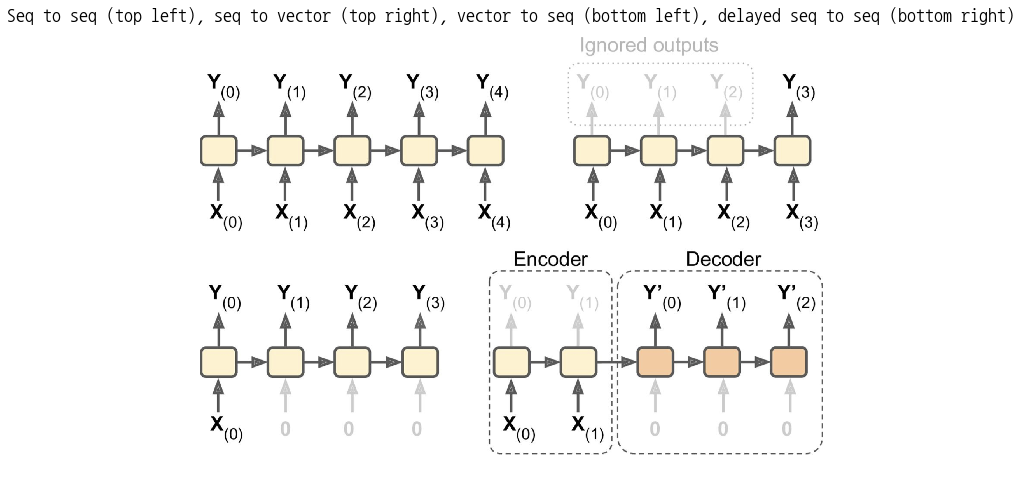

In [5]:
plt.figure(figsize=(12, 8))
plt.title("Seq to seq (top left), seq to vector (top right), vector to seq (bottom left), delayed seq to seq (bottom right)", fontsize=18)
plot_external2("./images/rnn/3.png")
plt.show()

위 그림(왼쪽 위)는 시퀀스-투-시퀀스(sequence-to-sequence)네트워크로, 예를 들어 주식가격 같은 시계열 데이터를 예측하는 데 유용합니다. 최근 N일치의 주식가격을 주입하면 네트워크는 하루 앞선 가격을 출력해야 합니다(즉, N-1일 전부터 내일까지).  

또는 입력 시퀀스를 네트워크에 주입하고, 마지막을 제외한 모든 출력을 무시할 수 있습니다(오른쪽 위의 네트워크). 이는 시퀀스-투-벡터(sequence-to-vector) 네트워크로, 예를 들어 영화 리뷰에 있는 연는 연속된 단어를 주입하면 네트워크는 감성 점수를 출력합니다(예를 들면 -1(싫다)에서부터 +1(좋다)까지).  

반대로 첫 번째 타임 스텝에서 단 하나의 입력만(다른 모든 타임 스텝에서는 0을) 네트워크에 주입하고, 출력 시퀀스를 연결할 수 있습니다(왼쪽 아래 네트워크). 이는 벡터-투-시퀀스(vector-to-sequence) 네트워크로, 예를 들어 이미지를 입력하여 이미지에 대한 캡션을 출력할 수 있습니다.  

또한 **인코더(encoder)**라 불리는 시퀀스-투-벡터 네트워크 뒤에 디코더(decoder)라 불리는 벡터-투-시퀀스 네트워크를 연결할 수 있습니다(오른쪽 아래 네트워크). 이는 지연된 시퀀스-투-시퀀스(delayed sequence-to-sequence) 네트워크로, 예를 들어 한 언어의 문장을 다른 언어로 번역하는 데 사용할 수 있습니다. 한 언어의 문장을 네트워크에 주입하면 인코더는 이 문장을 하나의 벡터표현으로 변환하고, 그 다음에 디코더가 이 벡터를 다른 언어의 문장으로 디코딩합니다. 인코더-디코더로 불리는 이런 이중 단계 모델은 하나의 시퀀스-투-시퀀스 RNN을 사용하여 한 단어씩 번역하는 것보다 훨씬 더 잘 작동합니다. 문장의 마지막 단어가 번역의 첫번째 단어에 영향을 줄 수 있기 때문입니다. 그래서 번역하기 전에 전체 문장이 주입될 때까지 기다릴 필요가 있습니다.

<br>
<br>

### 5.2 Basic RNNs in TensorFlow
내부 구조를 잘 이해하기 위해 먼저 텐서플로의 RNN 연산을 전혀 사용하지 않고 매우 간단한 RNN 모델을 구현해보겠습니다. tanh 활성화 함수를 사용하여 다섯 개의 순환 뉴런의 층으로 구성된 RNN을 만들겠습니다. 이 RNN은 타임 스텝마다 크기 3의 입력 베터를 받고 단지 2개의 타임 스텝에 대해서만 작동한다고 가정하겠습니다.

In [6]:
reset_graph()

n_inputs = 3
n_neurons = 5

X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

Wx = tf.Variable(tf.random_normal(shape=[n_inputs, n_neurons],dtype=tf.float32))
Wy = tf.Variable(tf.random_normal(shape=[n_neurons,n_neurons],dtype=tf.float32))
b = tf.Variable(tf.zeros([1, n_neurons], dtype=tf.float32))

Y0 = tf.tanh(tf.matmul(X0, Wx) + b)
Y1 = tf.tanh(tf.matmul(Y0, Wy) + tf.matmul(X1, Wx) + b)

init = tf.global_variables_initializer()

Instructions for updating:
Colocations handled automatically by placer.


이 네트워크는 같은 가중치와 편향을 양쪽 층이 공유한다는 점과 층마다 입력을 주입하고 출력을 얻는다는 점을 빼면 2개의 층이 있는 신경망과 매우 비슷합니다. 이 모델을 실행하려면 두 타임 스텝에 입력을 다음과 같이 주입해야 합니다.

In [7]:
import numpy as np

X0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]]) # t = 0
X1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]]) # t = 1

with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})

In [8]:
print(Y0_val)

[[-0.0664006   0.9625767   0.68105793  0.7091854  -0.898216  ]
 [ 0.9977755  -0.719789   -0.9965761   0.9673924  -0.9998972 ]
 [ 0.99999774 -0.99898803 -0.9999989   0.9967762  -0.9999999 ]
 [ 1.         -1.         -1.         -0.99818915  0.9995087 ]]


In [9]:
print(Y1_val)

[[ 1.         -1.         -1.          0.4020025  -0.9999998 ]
 [-0.12210419  0.62805265  0.9671843  -0.9937122  -0.2583937 ]
 [ 0.9999983  -0.9999994  -0.9999975  -0.85943305 -0.9999881 ]
 [ 0.99928284 -0.99999815 -0.9999058   0.9857963  -0.92205757]]
